# Differential Equations via Finite Differences

We now see our first application: solving differential equations.
We will focus on the following differential equations:

1. Indefinite integration:
$$
\begin{align*}
u(0) &= c, \\
u' &= f(x)
\end{align*}
$$
2. Linear time-evolution problems:
$$
\begin{align*}
u(0) &= c, \\
u' - a(x) u &= f(x)
\end{align*}
$$
2. Two-point boundary value problems:
$$
\begin{align*}
u(0) &= c_0, \\
u(1) &= c_1, \\
u'' - a(x) u &= f(x)
\end{align*}
$$
4. Nonlinear time-evolution problems:
$$
\begin{align*}
u(0) &= u_0, \\
u' &= f(u(x))
\end{align*}
$$

Our approach to solving these is to
1. Approximate the solution evaluated on a grid $(n+1)$-point grid
$x_1,…,x_n$ with _step size_
$$
x_{k+1}-x_k = h = {b-a \over n-1}
$$
for a vector $𝐮 ∈ ℝ^n$
that will be determined by solving a linear system:
$$
\begin{bmatrix}
u(x_1) \\
⋮ \\
u(x_n)
\end{bmatrix} ≈ \underbrace{\begin{bmatrix}
u_1 \\
⋮ \\
u_n
\end{bmatrix}}_𝐮
$$
2. Replace the derivatives with the finite-difference approximations (here $m_k = (x_{k+1} - x_k)/2$ is the mid-point
of the grid):
$$
\begin{align*}
u'(x_k) &≈ {u(x_{k+1}) - u(x_k) \over h} ≈ {u_{k+1} - u_k \over h} \qquad\hbox{(Forward-difference)} \\
u'(m_k) &≈ {u(x_{k+1}) - u(x_k) \over h} ≈ {u_{k+1} - u_k \over h} \qquad\hbox{(Central-difference)} \\
u'(x_k) &≈ {u(x_k) - u(x_{k-1}) \over h} ≈ {u_k - u_{k-1} \over h} \qquad\hbox{(Backward-difference)} \\
u''(x_k) &≈ {u(x_{k+1}) - 2u(x_k) + u_{k-1} \over h^2} ≈ {u_{k+1} - 2u_k + u_{k-1} \over h^2}
\end{align*}
$$
3. Recast the differential equation as a linear system whose solution
is $𝐮$, which we solve using numerical linear algebra.
Add the initial/boundary conditions as extra rows to make sure the
system is square.


**Remark (advanced)** One should almost never implement these methods oneselves as there
are packages available, e.g. [DifferentialEquations.jl]. Moreover Forward and Backward
Euler are only the first baby steps to a wide range of time-steppers, with Runge–Kutta being
one of the most successful.
For example we can solve
a simple differential equation like a pendulum $u'' = \sin u$ as follows:

In [1]:
using DifferentialEquations

# 1.  Time-evolution problems

In this section we consider the forward and backward Euler methods, which are based on forward and backward difference
approximations to the derivative. In the problem sheet we will investigate a rule that that takes the average of the two
(with significant benefits). We first discuss the simplest case of indefinite integration, then introduce forward and backward
Euler. We also consider systems of equations.


## Indefinite integration

We begin with the simplest differential equation on an interval $[a,b]$:
$$
\begin{align*}
u(0) &= c \\
u'(x) &= f(x)
\end{align*}
$$
Using the forward-difference (which is the standard finite-difference) approximation we get,
if $u_k ≈ u(x_k)$, for $k = 1, …, n-1$:
$$
u'(x_k) ≈ {u_{k+1} - u_k \over h} = f(x_k)
$$
We do not include $k = n$ to avoid going outside our grid.




Thus we have the rectangular system:
$$
\underbrace{{1 \over h} \begin{bmatrix}
-1 & 1\\
& \ddots & \ddots \\
&& -1 & 1
\end{bmatrix}}_{D_n} 𝐮^{\rm f} = \underbrace{\begin{bmatrix} f(x_1) \\ \vdots \\ f(x_{n-1})
\end{bmatrix}}_{𝐟^{\rm f}}
$$
where the super-script ${\rm f}$ denotes that this is leading towards the
forward Euler method.
Here $D_n ∈ ℝ^{n-1,n}$ so this system is not-invertible. Thus we need to
add an extra row, coming from the initial condition: $𝐞_1^⊤ 𝐮^n = c$,
that is:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_n
\end{bmatrix} 𝐮^{\rm f} = \underbrace{ \begin{bmatrix}
1 \\
-1/h & 1/h\\
& \ddots & \ddots \\
&& -1/h & 1/h
\end{bmatrix}}_L 𝐮^{\rm f} = \begin{bmatrix} c \\ 𝐟^{\rm f} \end{bmatrix}
$$
This is a lower-triangular bidiagonal system, so can be solved using
forward substitution in $O(n)$ operations. 

We can also consider discretisation at the mid-point $m_k = x_{k+1} - x_k \over 2$,
which is the analogue of using central-differences:
$$
u'(m_k) ≈ {u_{k+1} - u_k \over h} = f(m_k)
$$
That is, we have the exact same system with a different right-hand side:
$$
\underbrace{{1 \over h} \begin{bmatrix}
-1 & 1\\
& \ddots & \ddots \\
&& -1 & 1
\end{bmatrix}}_{D_n} 𝐮^{\rm m} = 
\underbrace{\begin{bmatrix} f(m_1) \\ \vdots \\ f(m_{n-1})
\end{bmatrix}}_{𝐟^{\rm m}}
$$

And of course there is $𝐮^{\rm B}$ coming from the backwards-difference
formula:
$$
u'(x_k) ≈ {u_k - u_{k-1} \over h} = f(x_k)
$$
which we leave as an exercise.


**Example**

Let's do an example of integrating $\cos x$, and see if our method matches
the true answer of $\sin x$. First we construct the system
as a lower-triangular, `Bidiagonal` matrix:

In [2]:
using LinearAlgebra, Plots

function indefint(x)
    h = step(x) # x[k+1]-x[k]
    n = length(x)
    L = Bidiagonal([1; fill(1/h, n-1)], fill(-1/h, n-1), :L)
end

n = 10
x = range(0, 1; length=n)
L = indefint(x)

10×10 Bidiagonal{Float64, Vector{Float64}}:
  1.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
 -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅     ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0    ⋅    ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0   9.0   ⋅ 
   ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅     ⋅   -9.0  9.0

We can now solve for our particular problem using both the left and 
mid-pint rules:

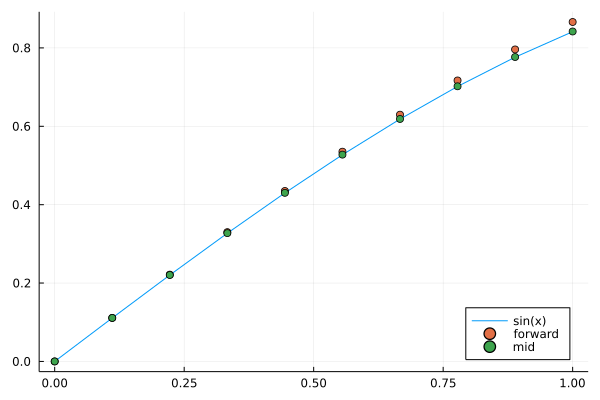

In [3]:
c = 0 # u(0) = 0
f = x -> cos(x)


m = (x[1:end-1] + x[2:end])/2 # midpoints


𝐟ᶠ = f.(x[1:end-1]) # evaluate f at all but last points
𝐟ᵐ = f.(m)          # evaluate f at mid-points
𝐮ᶠ = L \ [c; 𝐟ᶠ] # integrate using forward-differences
𝐮ᵐ = L \ [c; 𝐟ᵐ] # integrate using central-differences

plot(x, sin.(x); label="sin(x)", legend=:bottomright)
scatter!(x, 𝐮ᶠ; label="forward")
scatter!(x, 𝐮ᵐ; label="mid")

They both are close though the mid-point version is significantly
more accurate.
 We can estimate how fast it converges:

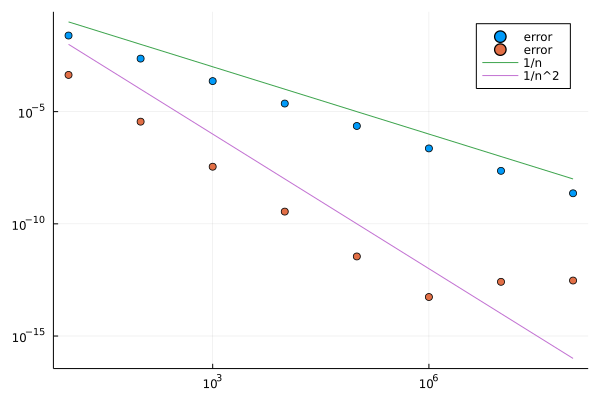

In [4]:
# Error from indefinite integration with c and f
function forward_err(u, c, f, n)
    x = range(0, 1; length = n)
    uᶠ = indefint(x) \ [c; f.(x[1:end-1])]
    norm(uᶠ - u.(x), Inf)
end

function mid_err(u, c, f, n)
    x = range(0, 1; length = n)
    m = (x[1:end-1] + x[2:end]) / 2 # midpoints
    uᵐ = indefint(x) \ [c; f.(m)]
    norm(uᵐ - u.(x), Inf)
end

ns = 10 .^ (1:8) # solve up to n = 10 million
scatter(ns, forward_err.(sin, 0, f, ns); xscale=:log10, yscale=:log10, label="error")
scatter!(ns, mid_err.(sin, 0, f, ns); label="error")
plot!(ns, ns .^ (-1); label="1/n")
plot!(ns, ns .^ (-2); label="1/n^2")

This is a log-log plot:we scale both $x$ and $y$ axes logarithmically so that
$n^α$ becomes a straight line where the slope is dictated by $α$.
We seem experimentally that the error for forward-difference is

A remarkable property here is that we are not seeing exponential growth in errors:
finite-differences is **stable** for solving differential equations! Even though
it was exponentially bad for _computing_ derivatives. 

## Forward Euler

Now consider
$$
\begin{align*}
u(0 ) &= c \\
u'(x) - α(x) u(x) &= f(x)
\end{align*}
$$

**Definition (Restriction matrices)**
Define the $n-1 × n$ _restriction matrices_ as
$$
\begin{align*}
    I_n^{\rm f} := \begin{bmatrix} 1 \\ &⋱ \\ &&1 & 0 \end{bmatrix}\\
I_n^{\rm b} := \begin{bmatrix} 0 & 1 \\ &&⋱ \\ &&&1  \end{bmatrix} \\
\end{align*}
$$


Again we can replace the discretisation using finite-differences, giving us
$$
{u_{k+1} - u_k \over h} - α(x_k) u_k = f(u_k)
$$
for $k = 1,…,n-1$. We need to add the term $α(x_k) u_k$ to our differential equation,
that is. We do this using the $n-1 × n$ _(left) restriction matrix_ that takes a vector
evaluated at $x_1,…,x_n$ and restricts it to $x_1,…,x_{n-1}$,
as well as the $n × n$ _multiplication matrix_
$$
A_n = \begin{bmatrix} α(x_0) \\ &⋱\\&& α(x_n) \end{bmatrix}
$$
Putting everything together we have the system:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_n -  I_n^{\rm L}  A_n
\end{bmatrix} 𝐮^n = \underbrace{ \begin{bmatrix}
1 \\
-α(x_0)-1/h & 1/h\\
& \ddots & \ddots \\
&& -α(x_{n-1})-1/h & 1/h
\end{bmatrix}}_L 𝐮^n = \begin{bmatrix} c \\ I_n^{\rm f} 𝐟 \end{bmatrix}
$$
where $𝐟 = \begin{bmatrix} f(x_0) \\ ⋮ \\ f(x_n) \end{bmatrix}$.

In [5]:
a = -1
c = 0
n = 2000
x = range(0, 1; length=n+1)
h = 1/n
A = Bidiagonal([1; fill(1/h, n)], fill(-a-1/h, n), :L)

norm(A \ [1; zeros(n)] - exp.(a*x),Inf)

9.198902547102872e-5

Note that this is a simple forward-substitution of a bidiagonal system,
so we can also just construct it directly:
$$
\begin{align*}
u_1 &= c \\
u_{k+1} &= u_k + h a(x_k) u_k + h f(x_k)
\end{align*}
$$


**Remark (advanced)** Note this can alternatively be reduced to an integral
$$
u(t) = c \hbox{e}^{a t} + \hbox{e}^{a x} \int_0^x f(t) \hbox{e}^{-a t} \hbox d t
$$
and solved as above but this approach is harder to generalise.


## Backward Euler


Backward Euler is a small modification where we replace the forward-difference with a backward-difference,
that is
$$
{u_k - u_{k-1} \over h} - a(x_k) u_k = f(u_k)
$$
We represent it using the $n-1 × n$ _(right) restriction matrix_ that takes a vector
evaluated at $x_1,…,x_n$ and restricts it to $x_2,…,x_n$,
Putting everything together we have the system:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_n -  I_n^{\rm R}  A_n
\end{bmatrix} 𝐮^n = \underbrace{ \begin{bmatrix}
1 \\
-α(x_1)-1/h & 1/h\\
& \ddots & \ddots \\
&& -α(x_{n-1})-1/h & 1/h
\end{bmatrix}}_L 𝐮^n = \begin{bmatrix} c \\ I_n^{\rm R} 𝐟 \end{bmatrix}
$$

We can turn it into code: The following solves.

In [6]:
c = 0
n = 20
x = range(0, 1; length=n+1)
h = 1/n
L = Bidiagonal([1; fill(1/h-a, n)], fill(-1/h, n), :L)

21×21 Bidiagonal{Float64, Vector{Float64}}:
   1.0     ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅     ⋅ 
 -20.0   21.0     ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅   -20.0   21.0     ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅   -20.0   21.0     ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅   -20.0   21.0        ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅   -20.0  …     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅   …     ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅      ⋅      ⋅         ⋅      ⋅      ⋅      ⋅     ⋅ 
    ⋅      ⋅      ⋅ 

In [7]:
norm(L \ [1; zeros(n)] - exp.(a*x),Inf)

0.009010041701558613

Again this is a bidiagonal forward-substitution:
$$
\begin{align*}
u_1 &= c \\
(1 - h a(x_{k+1})) u_{k+1} &= u_k + h f(x_{k+1})
\end{align*}
$$
That is,
$$
u_{k+1} = (1 - h a(x_{k+1}))^{-1}(u_k + h f(x_{k+1}))
$$



## Systems of equations

We can also solve systems, that is, equations of the form:
$$
\begin{align*}
𝐮(0) &= 𝐜 \\
𝐮'(x) - A(x) 𝐮(x) &= 𝐟(x)
\end{align*}
$$
where $𝐮(x) ∈ ℝ^d$ and $A(x) ∈ ℝ^{d × d}$.
We again discretise at the grid $x_k$
$$
𝐮^n = \begin{bmatrix} 𝐮_1 \\ ⋮ \\ 𝐮_n \end{bmatrix}
$$
where $𝐮(x_k) ≈ 𝐮_k ∈ ℝ^d$.
This can be reduced to a block-bidiagonal system as in
the scalar case which is solved via forward-substitution. Though
it's easier to think of it directly. 

Forward Euler gives us:
$$
\begin{align*}
𝐮_1 &= c \\
𝐮_{k+1} &= 𝐮_k + h A(x_k) 𝐮_k + h 𝐟(x_k)
\end{align*}
$$
That is, each time-step consists of matrix-vector multiplication.
On the other hand:
$$
\begin{align*}
𝐮_1 &= c \\
𝐮_{k+1} &= 𝐮_k + h A(x_k) 𝐮_k + h 𝐟(x_k)
\end{align*}
$$


. But it is 
sli


**Example**
Consider the (negative-time) Airy equation:
$$
\begin{align*}
u(0) &= 1 \\
u'(0) &= 0 \\
u''(x) + x u &= 0
\end{align*}
$$
We can recast it as a system by defining
$$
𝐮(x) = \begin{bmatrix} u(x) \\ u'(x) \end{bmatrix}
$$
which satisfies
$$
\begin{align*}
𝐮(0) = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
𝐮 + \begin{bmatrix} 0 & -1 \\ x & 0 \end{bmatrix} 𝐮 = 𝟎.
\end{align*}
$$
Thus we get

In [8]:
n = 100_000
x = range(0,1; length=n+1)
A = x -> [0 -1; 100x 0]
h = 1/n

I₂ = Matrix(I,2,2)
L = Bidiagonal([[I₂]; fill(-I₂/h,n)], fill(I₂/h, n) - A.(x[2:end]), :L)
𝐮 = L \ [[[1.,0]]; fill([0.,0],n)]

plot(x, [𝐮[k][1] for k=1:n+1])
plot!(x, [𝐮[k][2] for k=1:n+1])

## Nonlinear problems

Forward-Euler extends naturally to nonlinear equations, including the
vector case:
$$
𝐮' = f(x, 𝐮)
$$
becomes:
$$
𝐮_{k+1} = 𝐮_k + h f(x_k, 𝐮_k)
$$
Here we show a simple solution to a nonlinear Pendulum:
$$
u'' = \sin u
$$
by writing $𝐮 = [u,u']$ we have:
$$

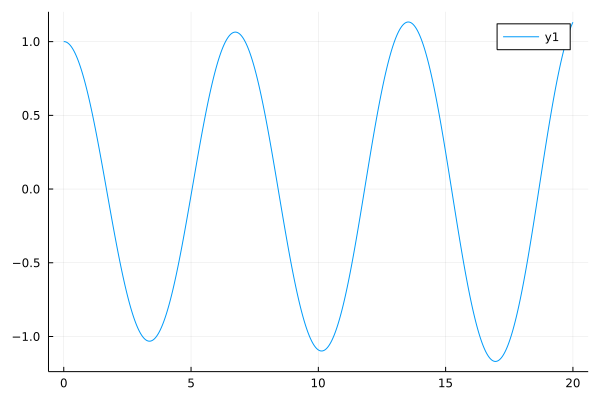

In [9]:
n = 1000
𝐮 = fill(zeros(2), n)
x = range(0, 20; length=n)
h = step(x) # same as x[k+1]-x[k]

𝐮[1] = [1,0]
for k = 1:n-1
    𝐮[k+1] = 𝐮[k] + h * [𝐮[k][2],-sin(𝐮[k][1])]
end

plot(x, first.(𝐮))

As we see it correctly predicts the oscillatory behaviour of
a pendulum.






## Long-time stability

As of now we have not presented a compelling case for the
backward-Euler method. We now present an example where it proves significantly
more accurate: consider

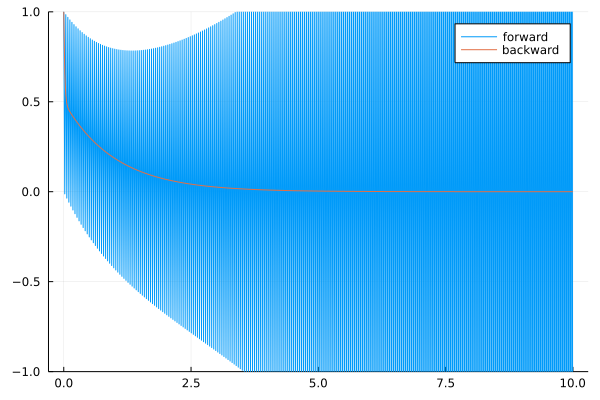

In [10]:
n = 500
𝐮 = fill(zeros(2), n)
𝐯 = fill(zeros(2), n)
x = range(0, 10; length=n)
h = step(x) # same as x[k+1]-x[k]

A = [-50.5 49.5;
      49.5 -50.5]

𝐯[1] = 𝐮[1] = [1,0]
for k = 1:n-1
    𝐮[k+1] = (I + h*A)*𝐮[k]
    𝐯[k+1] = (I - h*A)\𝐯[k]
end

plot(x, first.(𝐮); ylims=(-1,1), label="forward")
plot!(x, first.(𝐯); label="backward")

Here backward Euler successfully approximates the function
while forward Euler produces garbage.
(Note that we still have convergence for both methods
by making `n` even larger.)







# 2. Two-point boundary value problems

Here we will only consider one discretisation as it is symmetric:
$$
u''(x_k) ≈ {u_{k-1} - 2u_k + u_{k+1} \over h^2}
$$
That is we use the $n-1 × n+1$ matrix:
$$
D_h^2 := {1 \over h^2} \begin{bmatrix}
1 & -2 & 1 \\ & ⋱ & ⋱ & ⋱ \\
&& 1 & -2 & 1 
\end{bmatrix}
$$


**Example (Poisson)** Consider the Poisson equation with Dirichlet conditions:
$$
\begin{align*}
u(0) &= c_0 \\
u'' = f(x) \\
u(1) &= c_1
\end{align*}
$$
which we discretise as
$$
\begin{align*}
u_0 &= c_0 \\
 {u_{k-1} - 2u_k + u_{k+1} \over h^2} = f(x_k) \\
u_1 &= c_1
\end{align*}
$$
As a linear system this equation becomes:
$$
\begin{bmatrix}
𝐞_1^⊤ \\
D_h^2 \\
𝐞_{n+1}^⊤
\end{bmatrix} 𝐮^n = \begin{bmatrix} c_0 \\ S 𝐟 \\ c_1 \end{bmatrix}
$$

Thus we solve:

In [11]:
T = Tridiagonal([fill(1/h^2, n-1); 0], [1; fill(-2/h^2, n-1); 1], [0; fill(1/h^2, n-1)])

u = T \ [1; exp.(x[2:end-1]); 2]

plot(x, u)

LoadError: DimensionMismatch("arguments must have the same number of rows")

## Convergence



## 3. Matrix exponentials